<a href="https://colab.research.google.com/github/yang1325/AI_selfpraticenote/blob/main/tensorflow_covid/tensorflow_Coviddata_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#載入所需模組
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow import keras
import numpy as np
import pandas as pd
from numpy import load
from numpy import save
import random
import os
import gc
from datetime import datetime, timezone, timedelta
from time import sleep
from tqdm.notebook import tqdm 
tz = timezone(timedelta(hours=+8))
import time 

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
path = "/content/gdrive/My Drive/splited_data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from keras.layers.core import Lambda
from keras import backend as K

def weightedpool2D(x):
  return x[:,::2,::2]

def weightedpool2D_output_shape(input_shape):
    shape = list(input_shape)
    print(shape)
    shape[1] /= 2
    shape[2] /= 2
    return tuple(shape)

In [4]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape = (299,299,1)))
#cnn_model.add(layers.LayerNormalization())
cnn_model.add(Lambda(weightedpool2D,output_shape = weightedpool2D_output_shape))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.LayerNormalization())
cnn_model.add(layers.MaxPooling2D((3, 3)))
cnn_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn_model.add(layers.LayerNormalization())
cnn_model.add(layers.MaxPooling2D((3, 3)))
cnn_model.add(layers.Conv2D(512, (3, 3), activation='relu'))
cnn_model.add(layers.LayerNormalization())
cnn_model.add(layers.MaxPooling2D((3, 3)))
cnn_model.add(layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.35))
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.LayerNormalization())
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(1, activation="softmax"))
cnn_model.summary()
gc.collect()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      160       
                                                                 
 lambda (Lambda)             (None, 149, 149, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 128)     36992     
                                                                 
 layer_normalization (LayerN  (None, 147, 147, 128)    256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 256)       2

148

In [5]:
generator = models.Sequential()
generator.add(layers.Reshape((5000,),input_shape=(5,1000)))
generator.add(layers.Dense(1024, use_bias=False , activation='relu'))
generator.add(layers.BatchNormalization())
generator.add(layers.Dense(2048, use_bias=False , activation='relu'))
generator.add(layers.Dense(4*4*512, use_bias=False , activation='relu'))
generator.add(layers.Reshape((4,4,512)))
generator.add(layers.Conv2DTranspose(1024, (2, 2), strides=(1, 1),padding = "same"))
generator.add(layers.LeakyReLU(0.1))
generator.add(layers.Conv2DTranspose(512, (3, 3), strides=(3, 3)))
generator.add(layers.LeakyReLU(0.1))
generator.add(layers.Conv2DTranspose(256, (4, 4), strides=(3, 3), use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(0.1))
generator.add(layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(0.1))
generator.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(0.1))
generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation("sigmoid"))
generator.summary()
gc.collect()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5000)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              5120000   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 2048)              2097152   
                                                                 
 dense_5 (Dense)             (None, 8192)              16777216  
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                      

1247

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
EPOCHS = 50
noise_dim = 1000
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 5,1000])

In [8]:
batch = 10
@tf.function
def train_step(images):
    noise = tf.random.normal([batch, 5,1000])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = cnn_model(images, training=True)
      fake_output = cnn_model(generated_images * 255, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, cnn_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, cnn_model.trainable_variables))

In [9]:
fmt = '(%H:%M:%S)'
def train(epochs):
  gc.collect()
  for epoch in range(epochs):
    start = time.time()

    ran = np.array(random.sample(range(0,90),90))
    for j in range(4):
      epoch_loss_avg = tf.keras.metrics.Mean()
      epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
      if(j < 3):
        end = j*30+30
      else:
        ran = np.array(range(0,100))
        end = 100
      data = load(path + "/%d"%(ran[j*30]) + ".npy")
      label = load(path + "/%dy"%(ran[j*30]) + ".npy")
      for pic in range(j*30 + 1,end):
        tem = load(path + "/%d"%(ran[pic]) + ".npy")
        temy = load(path + "/%dy"%(ran[pic]) + ".npy")
        data = np.concatenate([data,tem],axis = 0)
        label = np.concatenate([label,temy],axis = 0)
        del tem
        del temy
      gc.collect()
      n = np.shape(data)[0]
      rand = np.array(random.sample(range(0,n),n))
      gc.collect()
      z = np.apply_along_axis(np.argmax,1,label)
      t = tf.convert_to_tensor(data)
      del data
      if(j<3):
        #cnn_model.fit(data, label, epochs=1,batch_size = batch,callbacks=[cp_callback])
        zoned_time1 = datetime.today().astimezone(tz)
        with tqdm(total=n) as pbar:
          pbar.set_description("%s%s:"%(("epoch:%d.%d,"%(epoch,j))
          ,zoned_time1.strftime(fmt)))
          for i in range(0,n,batch):
            image =  np.zeros((batch,299,299),dtype=int)
            y = np.zeros((batch,4),dtype=int)
            for l in range(batch):
              image[l,:,:] = t[rand[i+l]:rand[i+l]+1]
              #image[:,:,:,1] = t[i:(i+batch)]
              #image[:,:,:,2] = t[i:(i+batch)]
              y[l,:] = label[rand[i+l]:rand[i+l]+1]
            train_step(image)
            pbar.update(batch)
    generate_and_save_images(generator,epoch + 1,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [10]:
import matplotlib.pyplot as plt
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.show()

  0%|          | 0/6330 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

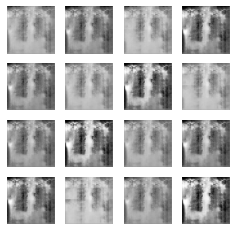

Time for epoch 1 is 692.6211321353912 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

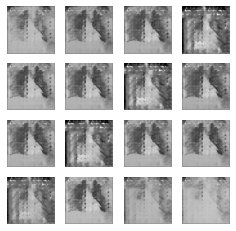

Time for epoch 2 is 671.8991639614105 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

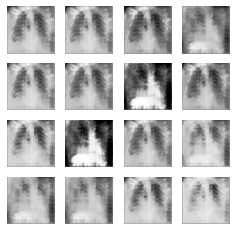

Time for epoch 3 is 680.2180042266846 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

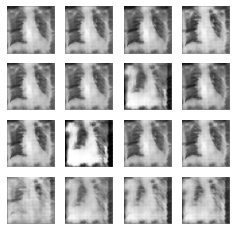

Time for epoch 4 is 669.9160890579224 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

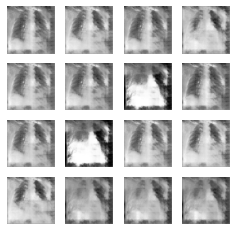

Time for epoch 5 is 665.1007149219513 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

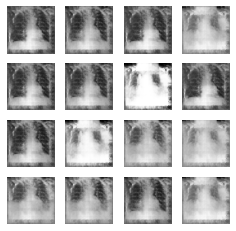

Time for epoch 6 is 667.4451448917389 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

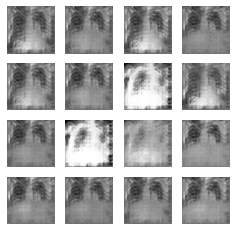

Time for epoch 7 is 660.8847503662109 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

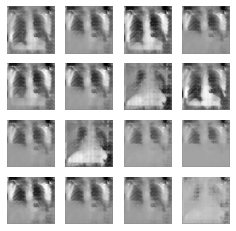

Time for epoch 8 is 665.1521339416504 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

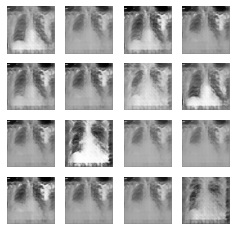

Time for epoch 9 is 666.7918431758881 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

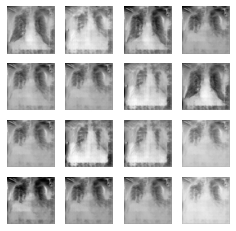

Time for epoch 10 is 666.8892524242401 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

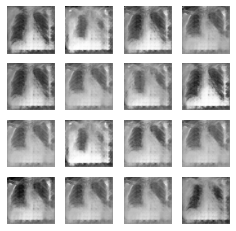

Time for epoch 11 is 669.1302678585052 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

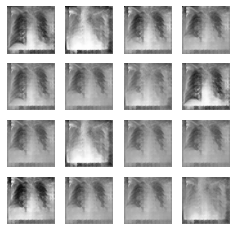

Time for epoch 12 is 661.2449913024902 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

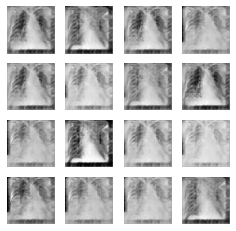

Time for epoch 13 is 664.7347965240479 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

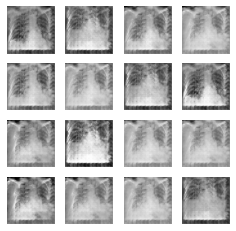

Time for epoch 14 is 675.2909338474274 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

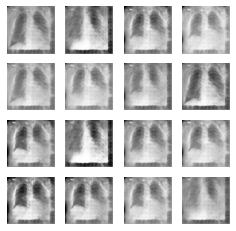

Time for epoch 15 is 670.4514451026917 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

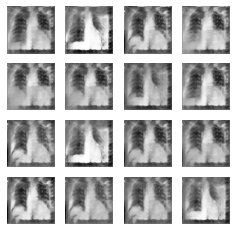

Time for epoch 16 is 662.0447235107422 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

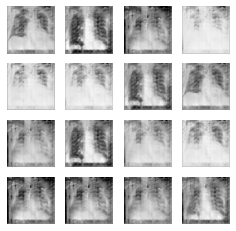

Time for epoch 17 is 670.3357193470001 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

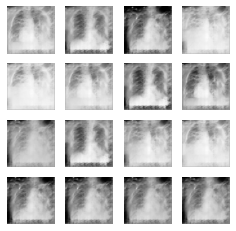

Time for epoch 18 is 664.282130241394 sec


  0%|          | 0/6330 [00:00<?, ?it/s]

  0%|          | 0/6330 [00:00<?, ?it/s]

In [ ]:
train(EPOCHS)